clean version available at:  
- https://github.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/tree/main/Seminar5

Installing packages:
```
# polara
pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style='white', context='paper')
%config InlineBackend.figure_format = "svg"

from polara import get_movielens_data
from polara.evaluation.pipelines import find_optimal_config, random_grid

from dataprep import transform_indices, leave_last_out, verify_time_split, reindex_data
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

# Prepraring data

In [2]:
data = get_movielens_data(include_time=True)

In [3]:
training_, holdout_ = leave_last_out(data, 'userid', 'timestamp')
verify_time_split(training_, holdout_)

In [4]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = (
    reindex_data(holdout_, data_index, filter_invalid=True)
    .sort_values('userid')
)

In [5]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    test_users = holdout[data_index['users'].name].values,
)

In [6]:
userid = data_description['users']
seen_idx_mask = training[userid].isin(data_description['test_users'])
testset = training[seen_idx_mask]

# SGD MF

$$
\begin{gather}
e_{ui} =  a_{ui} - p_u^\top q_i \\
\mathbb{p}_u\gets\mathbb{p}_u+\eta\left(e_{ui}\mathbb{q}_i-\lambda\mathbb{p}_u\right)\\
\mathbb{q}_i\gets\mathbb{q}_i+\eta\left(e_{ui}\mathbb{p}_u-\lambda\mathbb{q}_i\right)
\end{gather}
$$


In [8]:
training.head()

,userid,movieid,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3175,4,978300275
4,0,2161,5,978824291


In [33]:
from numba import njit, objmode, prange


def mf_sgd_build(config, data, data_description):
    useridx = data[data_description['users']].values
    itemidx = data[data_description['items']].values
    ratings = data[data_description['feedback']].values
    learning_rate = config['learning_rate']
    regularization = config['regularization']
    n_epochs = config['n_epochs']
    rank = config['rank']

    n_users = data_description['n_users']
    n_items = data_description['n_items']
    rng = np.random.default_rng(config.get('seed', None))

    P, Q, mse_history = sgd_epochs(
        useridx, itemidx, ratings,
        learning_rate, regularization, n_epochs,
        rank, n_users, n_items,
        rng
    )
    return P, Q, mse_history

@njit
def sgd_epochs(
    useridx, itemidx, ratings,
    learning_rate, regularization, n_epochs,
    rank, n_users, n_items,
    rng
):
    P = rng.normal(0, 0.01, (n_users, rank))
    Q = rng.normal(0, 0.01, (n_items, rank))
    history = []
    for epoch in range(n_epochs):
        mse = sgd_step(P, Q, useridx, itemidx, ratings, learning_rate, regularization, rng)
        history.append(mse)
        if (epoch+1) % 2 == 0:
            with objmode():
                signal  = evaluation_callback(epoch, P, Q)
                if signal == 0:
                    break
    return P, Q, history

def check_metric_growth(testset, holdout, data_description):
    def update_target_metric(metrics):
        hr, mrr, cov = metrics
        eval_callback.target_metrics.append(hr)

    def eval_callback(epoch, P, Q):
        mf_params = P, Q, None
        sgd_scores = mf_sgd_scoring(mf_params, None, data_description)
        downvote_seen_items(sgd_scores, testset, data_description)
        sgd_recs = topn_recommendations(sgd_scores, topn=10)
        metrics = model_evaluate(sgd_recs, holdout, data_description)
        update_target_metric(metrics)
        stopping_criteria = 1
        if len(eval_callback.target_metrics) >= 2:
            stopping_criteria = eval_callback.target_metrics[-1] > eval_callback.target_metrics[-2]
        return int(stopping_criteria)
    eval_callback.target_metrics = []
    return eval_callback

@njit
def sgd_step(P, Q, useridx, itemidx, ratings, learning_rate, regularization, rng):
    n_interactions = len(ratings)
    squared_err = 0.

    for idx in rng.permutation(n_interactions):
        userid = useridx[idx]
        itemid = itemidx[idx]
        rating = ratings[idx]

        pi = P[userid]
        qj = Q[itemid]

        error = rating - pi @ qj

        pi += learning_rate * (error*qj - regularization*pi)
        qj += learning_rate * (error*pi - regularization*qj)

        squared_err += error*error

    mse = squared_err / n_interactions
    return mse

def mf_sgd_scoring(params, data, data_description):
    P, Q, _ = params
    test_users = data_description['test_users']
    scores = P[test_users] @ Q.T
    return scores


In [11]:
config = {
    "rank": 30,
    "n_epochs": 20,
    "learning_rate": 1e-3,
    "regularization": 1,
    "seed": 20230711
}

In [35]:
evaluation_callback = check_metric_growth(testset, holdout, data_description)

sgd_params = mf_sgd_build(config, training, data_description)

In [36]:
evaluation_callback.target_metrics

[0.00016561775422325274,
 0.029314342497515734,
 0.030639284531301755,
 0.020039748261013582]

<Axes: >

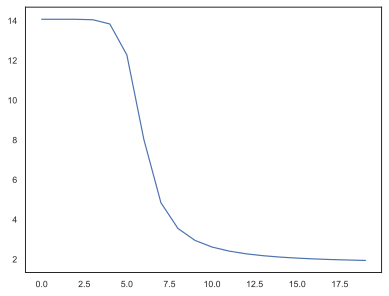

In [17]:
pd.Series(sgd_params[2]).plot()

In [18]:
sgd_params[-1]

[14.073806933726514,
 14.073534308235816,
 14.071274786913563,
 14.049001345344921,
 13.835806086890406,
 12.280476555416582,
 8.021538916605808,
 4.845118340881232,
 3.5504748950105274,
 2.9497322071556127,
 2.6166194218911567,
 2.4125040122640034,
 2.276062978093326,
 2.1812000686829704,
 2.1106431067323665,
 2.0598476264889145,
 2.019335208762668,
 1.9871147802933158,
 1.9648634267324439,
 1.9419081090587782]

In [19]:
sgd_scores = mf_sgd_scoring(sgd_params, None, data_description)
downvote_seen_items(sgd_scores, testset, data_description)

In [20]:
sgd_recs = topn_recommendations(sgd_scores, topn=10)
model_evaluate(sgd_recs, holdout, data_description)

(0.015071215634315998, 0.005719990325820073, 0.020518358531317494)

# Negative sampling

In [37]:
training.head()

,userid,movieid,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3175,4,978300275
4,0,2161,5,978824291


In [39]:
training.shape[0]

994169

In [40]:
training.shape[0]*2

1988338